## Understanding uncertainty in linear models 


In this lesson we are going to explore the use of Bayesian linear modeling in data analysis. In particular we are going to use uncertainty quantification as a tool dealing with multiple factors, and better understanding the results of a model. 

We are going to start with the problem of dealing with associations. 
Linear models, or statistical models in general, are tools that can be used to get insights about the world through the analysis of data. However, the answer we get from a model must be questioned and verified, by exploring the ability and uncertainty of the model in describing the data, and by challenging it against alternative hypothesis.

In [1]:
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt 

%run tools.py

This lesson is inspired by Chapter 5 of the book *Statistical Rethinking*. We will start analysing the dataset *WaffleDivorce* providing demographic information from the individual states of the Unisted States. It is structured as follows:

- Location : State name
- Loc : State abbreviation
- Population : 2010 population in millions
- MedianAgeMarriage: 2005-2010 median age at marriage
- Marriage : 2009 marriage rate per 1000 adults
- Marriage.SE : Standard error of rate
- Divorce : 2009 divorce rate per 1000 adults
- Divorce.SE : Standard error of rate
- WaffleHouses : Number of diners
- South : 1 indicates Southern State
- Slaves1860 : Number of slaves in 1860 census
- Population1860 : Population from 1860 census
- PropSlaves1860 : Proportion of total population that were slaves in 1860

In [2]:
data = pd.read_csv('WaffleDivorce.csv',sep=';')
print(data.columns)

Index(['Location', 'Loc', 'Population', 'MedianAgeMarriage', 'Marriage',
       'Marriage SE', 'Divorce', 'Divorce SE', 'WaffleHouses', 'South',
       'Slaves1860', 'Population1860', 'PropSlaves1860'],
      dtype='object')


Our first analysis consists in investigating the relationship between divorce rate and marriage rate:

In [3]:
data['Marriage_s'] = (data.Marriage - np.mean(data.Marriage))/np.std(data.Marriage)
data['MedianAgeMarriage_s'] = (data.MedianAgeMarriage - np.mean(data.MedianAgeMarriage))/np.std(data.MedianAgeMarriage)

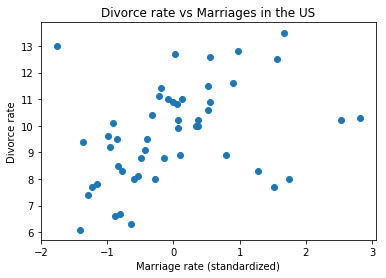

In [4]:
plt.scatter(data.Marriage_s,data.Divorce)
plt.xlabel('Marriage rate (standardized)')
plt.ylabel('Divorce rate')
plt.title('Divorce rate vs Marriages in the US')
plt.show()

The data seems to point to a pretty consistent association. What this could mean? Let's explore this association with our linear model.

In [5]:
expr = 'Divorce ~  Marriage_s'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

In [6]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)

      fun: 106.55497908930002
 hess_inv: array([[ 5.42360992e-02, -5.95832885e-04, -8.95320592e-05],
       [-5.95832885e-04,  5.44529856e-02,  2.32834996e-04],
       [-8.95320592e-05,  2.32834996e-04,  2.79281500e-02]])
      jac: array([-2.86102295e-06,  9.53674316e-07,  1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 140
      nit: 23
     njev: 28
   status: 0
  success: True
        x: array([9.68258673, 0.67327962, 1.67190698])


In [7]:
posterior_stats(solution_regression, ['a','b','sigma'])

           mean        SD      7.5%      92.5%
a      9.698993  0.234851  9.372237  10.039823
b      0.667153  0.228263  0.338732   0.997377
sigma  1.689547  0.170769  1.448201   1.943626


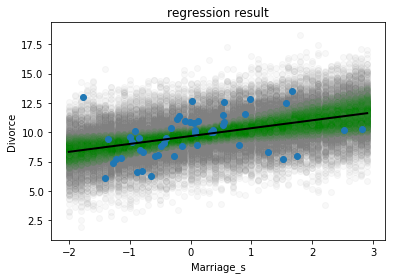

In [8]:
posterior_plot_univariate_regression(solution_regression, np.arange(-2,3,0.1), data, names = ['Marriage_s','Divorce'])

The model seems to support the existence of this association. For each point of increase in marriage rate, there seems to be roughly 0.7 increase in divorce rate.

Let's now explore the association between divorce rate and the median age of marriage.  

      fun: 99.29130616042909
 hess_inv: array([[ 4.74418249e-02, -9.61646360e-04,  8.06554818e-05],
       [-9.61646360e-04,  4.29243172e-02, -4.37304258e-04],
       [ 8.06554818e-05, -4.37304258e-04,  2.10839806e-02]])
      jac: array([-9.53674316e-07, -9.53674316e-07,  9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 110
      nit: 17
     njev: 22
   status: 0
  success: True
        x: array([ 9.6839518 , -1.07608209,  1.4457357 ])
           mean        SD      7.5%     92.5%
a      9.685467  0.209009  9.383160  9.991708
b     -1.073403  0.202736 -1.345341 -0.771680
sigma  1.447687  0.148546  1.234494  1.660632


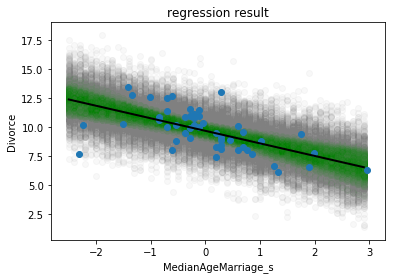

In [9]:
expr = 'Divorce ~  MedianAgeMarriage_s'
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,3,0.1), data, names = ['MedianAgeMarriage_s','Divorce'])

Even now the model seems to support this relationship. Which predictor is the best? 
The question we can ask with such a model are:

- If I know the marriage rate, what additional information age at marriage brings?
- If I know age at marriage, what additional information marriage rate brings?

We can try with some preliminary study, called *residual analysis*.
The idea consists in ''removing'' the effect of a predictor from the other, and then estimate the residual predictive power. Let's see this principle in action.

In [10]:
expr = 'MedianAgeMarriage_s ~  Marriage_s'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 62.0401496177439
 hess_inv: array([[ 9.80537203e-03, -5.99286800e-05,  1.20266584e-05],
       [-5.99286800e-05,  9.42018840e-03,  2.41501969e-05],
       [ 1.20266584e-05,  2.41501969e-05,  4.79653666e-03]])
      jac: array([9.53674316e-07, 1.43051147e-06, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 180
      nit: 11
     njev: 33
   status: 0
  success: True
        x: array([ 1.51985049e-09, -7.21026746e-01,  6.92835195e-01])
           mean        SD      7.5%     92.5%
a      0.000855  0.099096 -0.142433  0.143354
b     -0.722574  0.094069 -0.853726 -0.591826
sigma  0.695593  0.070739  0.588560  0.793199


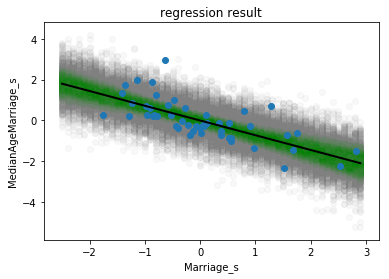

In [11]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,3,0.1), data, names = ['Marriage_s','MedianAgeMarriage_s'])

Once having computed the residuals, we can regress them against divorce rate:

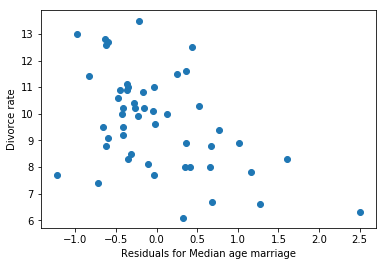

In [12]:
mean_preds = np.mean(post_sample_Laplace(solution_regression, 1000),0)
predictions_median_age_m = mean_preds[0] + data.Marriage_s * mean_preds[1]
residuals_median_age_m = data.MedianAgeMarriage_s - predictions_median_age_m

data['MedianAgeMarriage_residuals'] = residuals_median_age_m
plt.scatter(data.MedianAgeMarriage_residuals,data.Divorce)
plt.xlabel('Residuals for Median age marriage')
plt.ylabel('Divorce rate')
plt.show()



Even after removint the effect of marriage rate, there seem to be still some relationship left. Let's investigate this relationship to verify its extent.

**Exercise.** Find a 85% confidence bound for this association.

**Exercise.** Repeat the analysis by computing the residuals with respect to median age. 

What is the conclusion of this analysis?

This is the right moment to fit a model with both variables.

In [13]:
expr = 'Divorce ~  Marriage_s + MedianAgeMarriage_s'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 

prior_a_mean = 10
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_m_rate_mean = 0
prior_m_rate_sigma = 1
prior_m_rate = ['gaussian', [prior_m_rate_mean, prior_m_rate_sigma]]

prior_m_age_mean = 0
prior_m_age_sigma = 1
prior_m_age = ['gaussian', [prior_m_age_mean, prior_m_age_sigma]]

sigma_inf = 0
sigma_sup = 10
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_m_rate, prior_m_age, prior_sigma]

In [14]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','m_rate','m_age','sigma'])

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 97.18293295615163
 hess_inv: array([[ 0.03563027,  0.00190122,  0.002508  , -0.00023752],
       [ 0.00190122,  0.06853721,  0.04629096,  0.00198334],
       [ 0.002508  ,  0.04629096,  0.06871456,  0.0024577 ],
       [-0.00023752,  0.00198334,  0.0024577 ,  0.02079114]])
      jac: array([ 0.00000000e+00, -6.67572021e-06,  9.53674316e-06,  1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 130
      nit: 15
     njev: 21
   status: 0
  success: True
        x: array([ 9.68812941, -0.13226788, -1.12524411,  1.43998691])
            mean        SD      7.5%     92.5%
a       9.683718  0.187656  9.413283  9.962480
m_rate -0.134993  0.256985 -0.497654  0.243938
m_age  -1.123226  0.260219 -1.497525 -0.748104
sigma   1.443668  0.137255  1.243999  1.627899


            mean        SD      7.5%     92.5%
a       9.692663  0.189760  9.427713  9.963523
m_rate -0.127573  0.263455 -0.501783  0.228550
m_age  -1.119287  0.261676 -1.502821 -0.755533
sigma   1.443974  0.141171  1.249804  1.649116


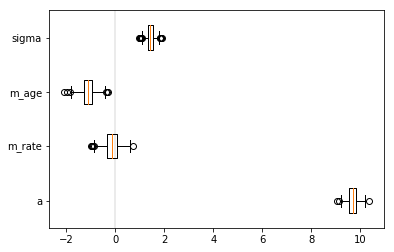

In [15]:
posterior_stats(solution_regression, ['a','m_rate','m_age','sigma'], plot = True)

What does this result tell us? That once age is known, there is little information that is brought by marriage rate for predicting divorces.

## Masking relationships

We are now going to investigate the issue of linear modeling when predictors behave similarly.

We are going to explore a dataset about primate milk composition (from Table 2 of Hinde and Milligan. 2011. Evolutionary Anthropology 20:9-23). The dataset is composed as follows:

- clade: Broad taxonomic group
- species: Species name
- kcal.per.g: Kilocalories per gram of milk
- perc.fat: Percent fat
- perc.protein: Percent protein
- perc.lactose: Percent lactose
- mass: Body mass of mother, in kilograms
- neocortex.perc: Percent of brain mass that is neocortex

In [16]:
data_milk = pd.read_csv('milk_clean.csv',sep=',')
print(data_milk.columns)

Index(['Unnamed: 0', 'clade', 'species', 'kcal.per.g', 'perc.fat',
       'perc.protein', 'perc.lactose', 'mass', 'neocortex.perc'],
      dtype='object')


We are interested in the relationship between the energy associated to the milk of a species, and the relative volume of the neocortex.  

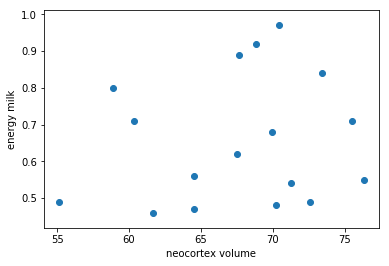

In [17]:
plt.scatter(data_milk['neocortex.perc'], data_milk['kcal.per.g'])
plt.xlabel('neocortex volume')
plt.ylabel('energy milk')
plt.show()


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 3.002310206951199
 hess_inv: array([[ 3.85100787e-05, -1.92541080e-05, -2.58027187e-07],
       [-1.92541080e-05,  9.62704673e-06,  1.29013593e-07],
       [-2.58027187e-07,  1.29013593e-07,  7.86674364e-04]])
      jac: array([ 3.57627869e-07,  2.91466713e-05, -4.76837158e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 351
      nit: 53
     njev: 69
   status: 2
  success: False
        x: array([0.3526191 , 0.00451377, 0.16569757])
           mean        SD      7.5%     92.5%
a      0.352919  0.006187  0.343866  0.361830
b      0.004363  0.003093 -0.000086  0.008891
sigma  0.166016  0.029226  0.125190  0.207224


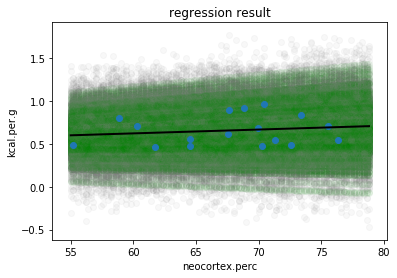

In [18]:
expr = 'kcal.per.g ~ neocortex.perc'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data_milk, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(55,79,0.2), data_milk, names = ['neocortex.perc','kcal.per.g'])

There is some sort of association, although not very strong. Here is instead the relationship between mil energy and (log) mass of the species: 

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 2.072219745648969
 hess_inv: array([[ 2.23814080e-03, -5.76030529e-04, -2.98569297e-06],
       [-5.76030529e-04,  3.89174000e-04, -9.41632081e-06],
       [-2.98569297e-06, -9.41632081e-06,  7.13085171e-04]])
      jac: array([-8.94069672e-07,  4.76837158e-07,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 237
      nit: 35
     njev: 47
   status: 0
  success: True
        x: array([ 0.70513978, -0.03168309,  0.15685834])
           mean        SD      7.5%     92.5%
a      0.703832  0.047412  0.636948  0.770619
b     -0.030671  0.019081 -0.057374 -0.002777
sigma  0.154999  0.026726  0.115956  0.192978


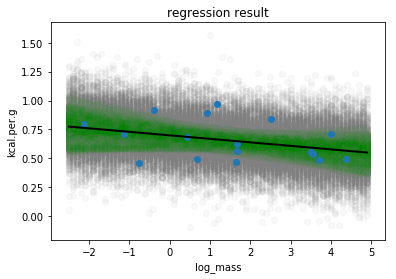

In [19]:
data_milk['log_mass'] = np.log(data_milk['mass'])

expr = 'kcal.per.g ~ log_mass'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 0
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 20
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, data_milk, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(-2.5,5,0.1), data_milk, names = ['log_mass','kcal.per.g'])

This association seems to be a bit stronger, although still not very strong. What happens when we consider the variables jontly? 

In [20]:
expr = 'kcal.per.g ~ log_mass + neocortex.perc'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 10
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_log_m_mean = 0
prior_log_m_sigma = 1
prior_log_m = ['gaussian', [prior_log_m_mean, prior_log_m_sigma]]

prior_neoc_mean = 0
prior_neoc_sigma = 1
prior_neoc = ['gaussian', [prior_neoc_mean, prior_neoc_sigma]]

sigma_inf = 0
sigma_sup = 10
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_log_m, prior_neoc, prior_sigma]

solution_regression_multiple = laplace_solution_regression(expr, data_milk, likelihood, priors)
posterior_stats(solution_regression_multiple, ['a','log_m','neocortex.perc','sigma'])


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: -3.001960151696201
 hess_inv: array([[ 1.99109966e-01,  7.03067326e-03, -3.09563202e-03,
         6.45754413e-04],
       [ 7.03067326e-03,  3.98061640e-04, -1.13822278e-04,
        -2.97227895e-05],
       [-3.09563202e-03, -1.13822278e-04,  4.84096212e-05,
        -9.60122022e-06],
       [ 6.45754413e-04, -2.97227895e-05, -9.60122022e-06,
         3.61598359e-04]])
      jac: array([4.41074371e-06, 2.08616257e-05, 3.44991684e-04, 1.43051147e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 620
      nit: 39
     njev: 100
   status: 2
  success: False
        x: array([-1.08404432, -0.09633655,  0.02791131,  0.11478599])
                    mean        SD      7.5%     92.5%
a              -1.093699  0.451525 -1.725799 -0.474213
log_m          -0.096510  0.019629 -0.123591 -0.067746
neocortex.perc  0.028043  0.007055  0.018386  0.037680
sigma           0.114302  0.019839  0.086069  0.144024


Both associations now seem much stronger. Let's explore them with what is called *counterfactual* prediction.

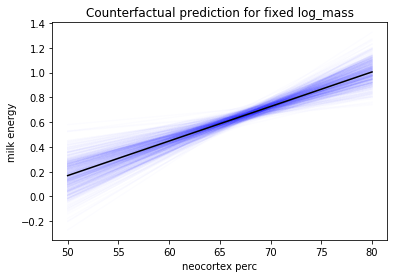

In [21]:
post_sample = post_sample_Laplace(solution_regression_multiple, 500)

neoc_range = np.linspace(50,80)
counterfactual_predict = []
for i in range(500):
    counterfactual_predict.append(post_sample [i,0] + post_sample[i,1] * np.mean(data_milk.log_mass) + post_sample[i,2] * neoc_range)
    plt.plot(neoc_range, counterfactual_predict[i], color = 'blue', alpha = 0.01)

plt.plot(neoc_range, np.mean(counterfactual_predict,0), color = 'black', alpha = 1)    
plt.xlabel('neocortex perc')
plt.ylabel('milk energy')
plt.title('Counterfactual prediction for fixed log_mass')
plt.show()

**Exercise.** Compute counterfactual prediction for log mass

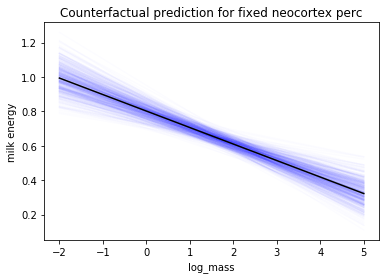

In [22]:
log_mass_range = np.linspace(-2,5)
counterfactual_predict = []
for i in range(500):
    counterfactual_predict.append(post_sample [i,0] + post_sample[i,1] * log_mass_range + post_sample[i,2] * np.mean(data_milk['neocortex.perc']))
    plt.plot(log_mass_range, counterfactual_predict[i], color = 'blue', alpha = 0.01)

plt.plot(log_mass_range, np.mean(counterfactual_predict,0), color = 'black', alpha = 1)  

plt.xlabel('log_mass')
plt.ylabel('milk energy')
plt.title('Counterfactual prediction for fixed neocortex perc')
plt.show()

How can this be possible? To understand this point we need to think of the meaning of a question asked by a linear model. For a given value of neocortex volume, the relationship between mass and milk enrgy is negative. In the same way, for a given value of mass, the relationship between neocortex volume and milk enrgy is positive. 

The fact is that the two variables are already correlated but also inversely associated with the target, and therefore they mask their respective effect out.

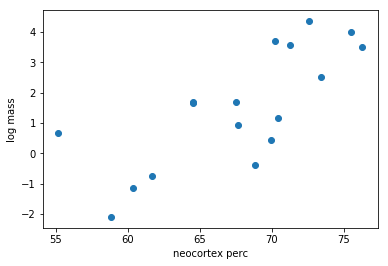

In [23]:
plt.scatter(data_milk['neocortex.perc'], data_milk['log_mass'])
plt.xlabel('neocortex perc')
plt.ylabel('log mass')
plt.show()

## Collinearity

In this example we design a synthetic dataset of body measurements from kids. 
We suppose a population with height distributed around $50cm$, and with standard deviation of $10$.
We then simulate measurement of the lenght of left and right legs, as a fraction of the height plus measurement noise.


In [26]:
N = 100
height = norm.rvs(50,10,N)

leg_proportion = uniform.rvs(0.43, 0.46, N)

In [27]:

left_leg = norm.rvs(leg_proportion * height, 2)
right_leg = norm.rvs(leg_proportion* height, 2)

left_leg = np.array(left_leg)
right_leg = np.array(right_leg)

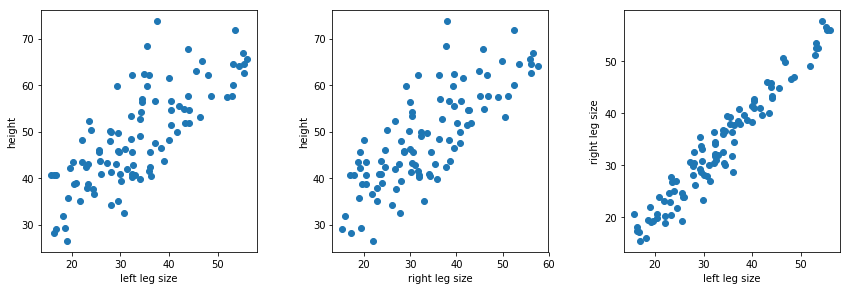

In [28]:
plt.subplot(1, 3, 1)
plt.scatter(left_leg, height)
plt.xlabel('left leg size')
plt.ylabel('height')

plt.subplot(1, 3, 2)
plt.scatter(right_leg, height)
plt.xlabel('right leg size')
plt.ylabel('height')

plt.subplot(1, 3, 3)
plt.scatter(left_leg, right_leg)
plt.xlabel('left leg size')
plt.ylabel('right leg size')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=1.95, hspace=0.25,
                    wspace=0.35)

Given this new set of measurements, let's study their association through our multivariate linear model.

In [29]:
data_height = pd.DataFrame({'height': height, 'left_leg': left_leg, 'right_leg': right_leg})

In [30]:
expr = 'height ~ left_leg + right_leg'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 50
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_left_mean = 0
prior_left_sigma = 10
prior_left = ['gaussian', [prior_left_mean, prior_left_sigma]]

prior_right_mean = 0
prior_right_sigma = 10
prior_right = ['gaussian', [prior_right_mean, prior_right_sigma]]

sigma_inf = 0
sigma_sup = 10
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_left, prior_right, prior_sigma]

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 344.3285528505123
 hess_inv: array([[ 4.24754176e+00, -1.64608445e-01,  4.83314140e-02,
         7.11290517e-02],
       [-1.64608445e-01,  3.91654646e-02, -3.41592986e-02,
        -4.56255286e-03],
       [ 4.83314140e-02, -3.41592986e-02,  3.26837503e-02,
         2.48182271e-03],
       [ 7.11290517e-02, -4.56255286e-03,  2.48182271e-03,
         1.96697397e-01]])
      jac: array([ 0.00000000e+00, -3.81469727e-06, -7.62939453e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 223
      nit: 25
     njev: 37
   status: 0
  success: True
        x: array([22.96334629,  0.19442792,  0.57316879,  6.56180463])
            mean        SD       7.5%      92.5%
a      22.973595  2.003492  20.128245  25.800064
left    0.195004  0.198433  -0.081964   0.475891
right   0.572275  0.178945   0.311991   0.827476
sigma   6.564019  0.436112   5.941491   7.194311


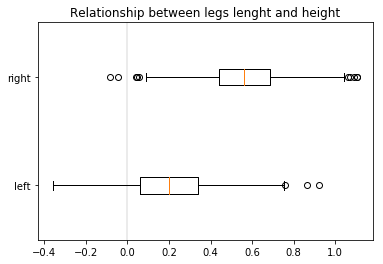

In [31]:
solution_regression_height = laplace_solution_regression(expr, data_height, likelihood, priors)
posterior_stats(solution_regression_height, ['a','left','right','sigma'])

posterior_samples = post_sample_Laplace(solution_regression_height, 1000)

boxes = []
boxes.append(posterior_samples[:,1])
boxes.append(posterior_samples[:,2])

plt.boxplot(boxes,vert=0)
plt.yticks([1,2], ['left', 'right'])
plt.axvline(x=0, color = 'black', alpha = 0.1)
plt.title('Relationship between legs lenght and height')
plt.show()

What can we say about this result? Is this convincing?
Let's explore the relationship between left and right legs lenght: 

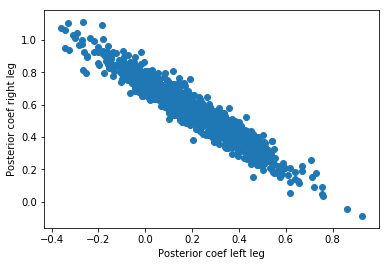

In [52]:
plt.scatter(posterior_samples[:,1] , posterior_samples[:,2])
plt.xlabel('Posterior coef left leg')
plt.ylabel('Posterior coef right leg')
plt.show()

Since the variables are extremely correlated (collinear), once the model knows one of them, the knowledge of the other one is not necessary anymore. That's the reason for the high uncertainty associated to the parameters.

If $x_l$ is the lenght of the left leg, and $x_r$ is the lenght of the right one, and $x_l ~ x_r$, then a linear model of the form

$ height = \alpha + \beta_l x_l + \beta_r x_r,$

is equivalent to

$ height = \alpha + (\beta_l  + \beta_r) x_l.$

Therefore any combination of $(\beta_l, \beta_r)$ giving the same total is an acceptable solution for this model.
Let's verify this by summing the model coefficients:

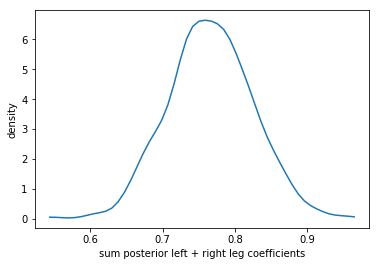

In [59]:
post_sum = posterior_samples[:,1] + posterior_samples[:,2]

kernel = gaussian_kde(post_sum)
plt.plot(np.linspace(np.min(post_sum),np.max(post_sum)),kernel(np.linspace(np.min(post_sum),np.max(post_sum))))
plt.xlabel('sum posterior left + right leg coefficients')
plt.ylabel('density')
plt.show()


In [54]:
print('The mean sum of the parameters is: ', np.mean(post_sum))
print('85% Confidence interval for the sum of the parameters: \n', np.quantile(post_sum, q = [0.075, 0.925], axis = 0))

The mean sum of the parameters is:  0.7662635162802712
85% Confidence interval for the sum of the parameters: 
 [0.68082546 0.85162699]


Now we compare this distribution to the posterior distribution of the coefficient obtained by using only one between right and left leg measurements: 

In [55]:
expr = 'height ~ right_leg '

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 50
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_left_mean = 0
prior_left_sigma = 10
prior_left = ['gaussian', [prior_left_mean, prior_left_sigma]]

sigma_inf = 1
sigma_sup = 5
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_left, prior_sigma]

solution_regression_height = laplace_solution_regression(expr, data_height, likelihood, priors)
posterior_stats(solution_regression_height, ['a','right','sigma'])

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 341.62351528292766
 hess_inv: array([[ 6.24016209e-01, -1.69364517e-02, -8.92616537e-02],
       [-1.69364517e-02,  5.10334382e-04,  1.82208186e-03],
       [-8.92616537e-02,  1.82208186e-03,  1.30306542e-01]])
      jac: array([-0.04980087, -2.60417557, -3.40684509])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 205
      nit: 16
     njev: 38
   status: 2
  success: False
        x: array([23.36344464,  0.7542327 ,  5.99672311])
            mean        SD       7.5%      92.5%
a      23.330712  0.791396  22.209867  24.506618
right   0.755466  0.023023   0.722178   0.788460
sigma   6.000173  0.357209   5.458070   6.511803


In [57]:
expr = 'height ~ left_leg '

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 50
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_left_mean = 0
prior_left_sigma = 5
prior_left = ['gaussian', [prior_left_mean, prior_left_sigma]]

sigma_inf = 1
sigma_sup = 5
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_left, prior_sigma]

solution_regression_height = laplace_solution_regression(expr, data_height, likelihood, priors)
posterior_stats(solution_regression_height, ['a','left','sigma'])

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/mini

      fun: 346.0657188782503
 hess_inv: array([[ 2.75168841e-01, -6.56385531e-03, -5.42882702e-02],
       [-6.56385531e-03,  1.97209715e-04, -9.01068568e-05],
       [-5.42882702e-02, -9.01068568e-05,  8.50485876e-02]])
      jac: array([  3.50823975, 119.59093857,  -5.27908325])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 256
      nit: 22
     njev: 48
   status: 2
  success: False
        x: array([24.21221543,  0.77051504,  5.97165262])
            mean        SD       7.5%      92.5%
a      24.219854  0.509152  23.488063  24.961945
left    0.770366  0.014118   0.750425   0.789836
sigma   5.964339  0.299007   5.538764   6.390268


**Exercise.** By exploring our first dataset, it seems that the number of Waffle houses in a state is related to the divorce rate. How can you explin this result? 

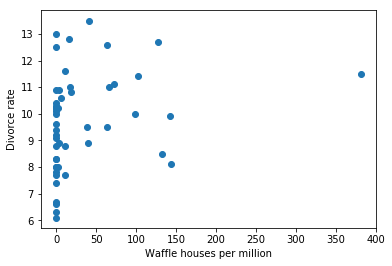

In [57]:
plt.scatter(data.WaffleHouses,data.Divorce)
plt.xlabel('Waffle houses per million')
plt.ylabel('Divorce rate')
plt.show()

In [58]:
expr = 'Divorce ~   WaffleHouses'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 178
prior_a_sigma = 100
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 10
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 0
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 112.8102252565369
 hess_inv: array([[ 5.31815414e-02, -3.27861906e-04, -1.13750184e-02],
       [-3.27861906e-04,  1.34634788e-05,  6.64223351e-05],
       [-1.13750184e-02,  6.64223351e-05,  2.58512862e-02]])
      jac: array([9.53674316e-07, 1.90734863e-06, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 208
      nit: 30
     njev: 41
   status: 0
  success: True
        x: array([9.46150847e+00, 7.03512238e-03, 1.74317412e+00])
           mean        SD      7.5%     92.5%
a      9.464173  0.227704  9.145865  9.796946
b      0.007004  0.003802  0.001523  0.012669
sigma  1.750160  0.158254  1.531221  1.979349


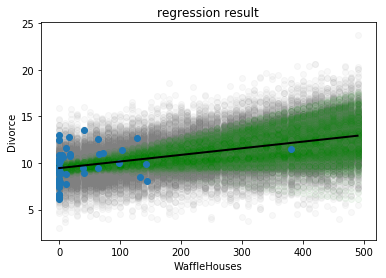

In [59]:
solution_regression = laplace_solution_regression(expr, data, likelihood, priors)
posterior_stats(solution_regression, ['a','b','sigma'])
posterior_plot_univariate_regression(solution_regression, np.arange(0,500,10), data, names = ['WaffleHouses','Divorce'])

**Exercise.** Analyse the relationship of milk energy with respect to percentage of fat and percentage of lactose.

## Comparing Bayesian Models: The Widely Applicable Information Criterion
   
The Widely Applicable Information Criterion (WAIC) is an information criterion (such as AIC or BIC) that can be used in Bayesian models. The interesting aspect of the WAIC is that it is completely based on the likelihood of the posterior predictions. To compute the WAIC we have simply to be able to compute samples from the posterior, no matter which kind of posterior we are working with.

Let's $y_i$ be a target point in the training sample, we define $Pr(y_i)$ the average likelihood of the point under our model. This means that for each combination of posterior parameters of our model we can compute the associated likelihood of the point, and then average across all the likelihoods. This quantity is called *log-pointwise-predictive-density* (lppd):

$$ lppd = \sum_{i=1}^N \log[Pr(y_i)]. $$

This is the equivalent of the deviance that is computed when computing the AIC. 
While *lppd* accounts for model fit, the second part of WAIC should penalize model complexity. Instead of computing the number of parameters, as in AIC or BIC, WAIC computed the variance $V(y_i)$ of the log-likelihood associated to each data point. In practice, we compute the likelihood of $y_i$ for each combination of parameters from our posterior, and then we compute the variance of these quantities. We therefore define the effective number of parameters $p_{WAIC}$ as:

$$ p_{WAIC} = \sum_{i=1}^N V(y_i) .$$

WAIC is finally defined as 

$$ WAIC = -2 (lppd - p_{WAIC}) $$


  

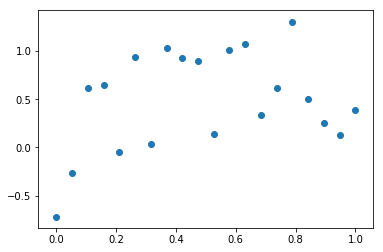

In [63]:
N = 20
noise = 0.4
x = np.linspace(0,1,N)
y = np.sin(x*3) + noise * np.random.randn(N)

data_synth = pd.DataFrame({'x' : x, 'y' : y})

plt.scatter(x,y)

In [64]:
degree = 10
likelihood = 'gaussian'

models = []

for i in range(degree):
    
    data_poly = pd.DataFrame({'y' : y})

    priors = []

    prior_a_mean = 0
    prior_a_sigma = 5
    prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

    priors.append(prior_a)
    
    if i > 0:
        expr = 'y ~ '
        for k in range(1,i+1):
            if k>1:
                expr = expr + '+'
            prior_param_mean = 0
            prior_param_sigma = 5
            prior_param = ['gaussian', [prior_param_mean, prior_param_sigma]]
            priors.append(prior_param)
            data_poly['x'+str(k)] = x**k
            expr = expr + 'x' + str(k)

    sigma_inf = 0.1
    sigma_sup = 5
    prior_sigma_unif = [sigma_inf, sigma_sup]
    prior_sigma = ['uniform', prior_sigma_unif]

    priors.append(prior_sigma)
    
    if i > 0:
        models.append(laplace_solution_regression(expr, data_poly, likelihood, priors))
    else:
        models.append(laplace_solution([1,1],[],data_poly['y'], likelihood, priors))    

      fun: 18.733561669426877
 hess_inv: array([[ 1.26659527e-02, -3.15436051e-05],
       [-3.15436051e-05,  6.30096263e-03]])
      jac: array([ 0.00000000e+00, -2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 63
      nit: 8
     njev: 15
   status: 0
  success: True
        x: array([0.48989106, 0.50188153])


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 20.359116900470696
 hess_inv: array([[ 0.04113245, -0.05888718, -0.00036395],
       [-0.05888718,  0.11763606,  0.0008919 ],
       [-0.00036395,  0.0008919 ,  0.0056625 ]])
      jac: array([0.00000000e+00, 0.00000000e+00, 2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 169
      nit: 17
     njev: 33
   status: 0
  success: True
        x: array([0.24783756, 0.48437245, 0.47970292])
      fun: 18.58568003119649
 hess_inv: array([[ 4.73156009e-02, -1.76175618e-01,  1.39634086e-01,
         6.18403475e-04],
       [-1.76175618e-01,  9.55344923e-01, -8.86684379e-01,
        -3.71729810e-03],
       [ 1.39634086e-01, -8.86684379e-01,  8.92810479e-01,
         3.70842827e-03],
       [ 6.18403475e-04, -3.71729810e-03,  3.70842827e-03,
         3.54644473e-03]])
      jac: array([8.10623169e-06, 4.52995300e-06, 4.29153442e-06, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 192
      nit: 26
     njev: 32
   status: 

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 21.092227269729065
 hess_inv: array([[ 5.61362625e-02, -2.74910680e-01,  3.85182509e-01,
        -1.62817236e-01,  2.75393346e-03],
       [-2.74910680e-01,  2.39376104e+00, -4.68009790e+00,
         2.58930264e+00, -1.37052916e-02],
       [ 3.85182509e-01, -4.68009790e+00,  1.11973125e+01,
        -7.14765520e+00,  2.51338267e-02],
       [-1.62817236e-01,  2.58930264e+00, -7.14765520e+00,
         4.99790740e+00, -1.54790740e-02],
       [ 2.75393346e-03, -1.37052916e-02,  2.51338267e-02,
        -1.54790740e-02,  3.80236639e-03]])
      jac: array([-1.90734863e-06, -2.38418579e-07,  2.38418579e-07,  4.76837158e-07,
       -7.15255737e-07])
  message: 'Optimization terminated successfully.'
     nfev: 305
      nit: 29
     njev: 43
   status: 0
  success: True
        x: array([-0.25731181,  3.55753643, -2.65379089, -0.46880164,  0.37890907])


/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 23.601580787377202
 hess_inv: array([[ 6.67524793e-02, -3.44199269e-01,  4.01377758e-01,
         6.10676610e-02, -1.87210788e-01,  2.31147793e-03],
       [-3.44199269e-01,  2.89534223e+00, -4.81779539e+00,
         7.93875952e-01,  1.55393171e+00, -2.27831671e-02],
       [ 4.01377758e-01, -4.81779539e+00,  1.16093318e+01,
        -7.73921848e+00,  3.39788884e-01,  3.68951997e-02],
       [ 6.10676610e-02,  7.93875952e-01, -7.73921848e+00,
         1.52675630e+01, -8.47192963e+00, -6.43306084e-04],
       [-1.87210788e-01,  1.55393171e+00,  3.39788884e-01,
        -8.47192963e+00,  7.06291165e+00, -1.61808152e-02],
       [ 2.31147793e-03, -2.27831671e-02,  3.68951997e-02,
        -6.43306084e-04, -1.61808152e-02,  4.41310820e-03]])
      jac: array([ 2.38418579e-06,  0.00000000e+00, -4.76837158e-07, -1.19209290e-06,
       -9.53674316e-07, -2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 326
      nit: 25
     njev: 40
   status: 0
  success

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 28.62815167424563
 hess_inv: array([[ 7.07266002e-02, -3.33198809e-01,  3.35552787e-01,
         9.61566657e-02, -8.14927571e-02, -8.19478415e-02,
        -8.46841645e-03,  1.38420781e-03],
       [-3.33198809e-01,  2.73189032e+00, -4.29867868e+00,
        -1.70871683e-01,  2.15961110e+00,  7.61134252e-01,
        -8.16235150e-01, -1.36588974e-02],
       [ 3.35552787e-01, -4.29867868e+00,  1.00945456e+01,
        -2.11639106e+00, -7.67074911e+00, -6.87601641e-01,
         4.35516369e+00,  2.15275140e-02],
       [ 9.61566657e-02, -1.70871683e-01, -2.11639106e+00,
         2.43804478e+00,  2.75267801e+00, -5.31368783e-01,
        -2.59319366e+00, -1.59073813e-03],
       [-8.14927571e-02,  2.15961110e+00, -7.67074911e+00,
         2.75267801e+00,  1.13813042e+01, -6.77310864e+00,
        -1.88065620e+00, -9.31493591e-03],
       [-8.19478415e-02,  7.61134252e-01, -6.87601641e-01,
        -5.31368783e-01, -6.77310864e+00,  1.52315823e+01,
        -7.89487206e+00, -4.46250764e

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 31.150779092043088
 hess_inv: array([[ 6.26498176e-02, -3.11493138e-01,  3.19077889e-01,
         9.99577409e-02, -6.97491491e-02, -8.43017320e-02,
        -4.54445299e-02,  2.59131002e-02,  2.05812907e-03],
       [-3.11493138e-01,  2.70823893e+00, -4.56865130e+00,
         3.23641973e-01,  1.51316771e+00,  1.21467838e+00,
         4.61006213e-02, -8.91958684e-01, -1.56699182e-02],
       [ 3.19077889e-01, -4.56865130e+00,  1.23988642e+01,
        -6.93980970e+00, -3.20758414e+00, -1.97141802e+00,
         2.12068764e+00,  1.88152309e+00,  2.28364717e-02],
       [ 9.99577409e-02,  3.23641973e-01, -6.93980970e+00,
         1.50761940e+01, -7.27374056e+00, -6.02253842e-01,
        -3.76759239e+00,  2.98565968e+00,  4.56120943e-03],
       [-6.97491491e-02,  1.51316771e+00, -3.20758414e+00,
        -7.27374056e+00,  1.77686318e+01, -4.91017326e+00,
        -2.30295046e+00, -1.65694694e+00, -9.14533885e-03],
       [-8.43017320e-02,  1.21467838e+00, -1.97141802e+00,
        -6

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 33.67436586234483
 hess_inv: array([[ 5.82816150e-02, -2.97079368e-01,  3.12525929e-01,
         7.86561501e-02, -3.81328860e-02, -1.17994294e-01,
        -4.08097150e-02,  1.83452425e-02,  2.06862525e-02,
         2.38994366e-03],
       [-2.97079368e-01,  2.66515703e+00, -4.47901405e+00,
         2.17562741e-01,  1.41188174e+00,  1.49571414e+00,
         9.01377717e-02, -6.92119098e-01, -3.85323635e-01,
        -2.29220530e-02],
       [ 3.12525929e-01, -4.47901405e+00,  1.15973555e+01,
        -4.79790313e+00, -5.52012594e+00, -1.51248588e+00,
         2.27273439e+00,  2.78169442e+00, -6.22234990e-01,
         3.48610719e-02],
       [ 7.86561501e-02,  2.17562741e-01, -4.79790313e+00,
         7.53900413e+00,  3.01696790e+00, -3.66467103e+00,
        -5.30215701e+00, -2.23181221e+00,  5.10471594e+00,
        -8.60030086e-04],
       [-3.81328860e-02,  1.41188174e+00, -5.52012594e+00,
         3.01696790e+00,  6.58715745e+00, -5.07950748e+00,
        -5.22019306e-01,  1.41

/Users/mlorenzi/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: 36.196835079552656
 hess_inv: array([[ 5.62491681e-02, -2.87073731e-01,  2.98447776e-01,
         1.02044036e-01, -4.82082352e-02, -9.25663034e-02,
        -8.71350146e-02, -3.01529277e-02,  1.43727391e-02,
         6.52413453e-02,  2.16389160e-03],
       [-2.87073731e-01,  2.59390990e+00, -4.28937959e+00,
        -2.39065881e-01,  1.48509304e+00,  1.41199312e+00,
         7.27731360e-01, -9.26480943e-02, -5.63072377e-01,
        -7.17409856e-01, -1.95893926e-02],
       [ 2.98447776e-01, -4.28937959e+00,  1.06296406e+01,
        -2.93201405e+00, -5.30234349e+00, -2.64302247e+00,
         4.60411702e-01,  2.30561866e+00,  1.93712966e+00,
        -4.03412188e-01,  2.66945921e-02],
       [ 1.02044036e-01, -2.39065881e-01, -2.93201405e+00,
         5.31497576e+00,  2.45865533e+00, -1.43826581e+00,
        -3.86106805e+00, -3.46105816e+00, -5.80233663e-01,
         4.60715603e+00,  4.14187801e-03],
       [-4.82082352e-02,  1.48509304e+00, -5.30234349e+00,
         2.45865533e

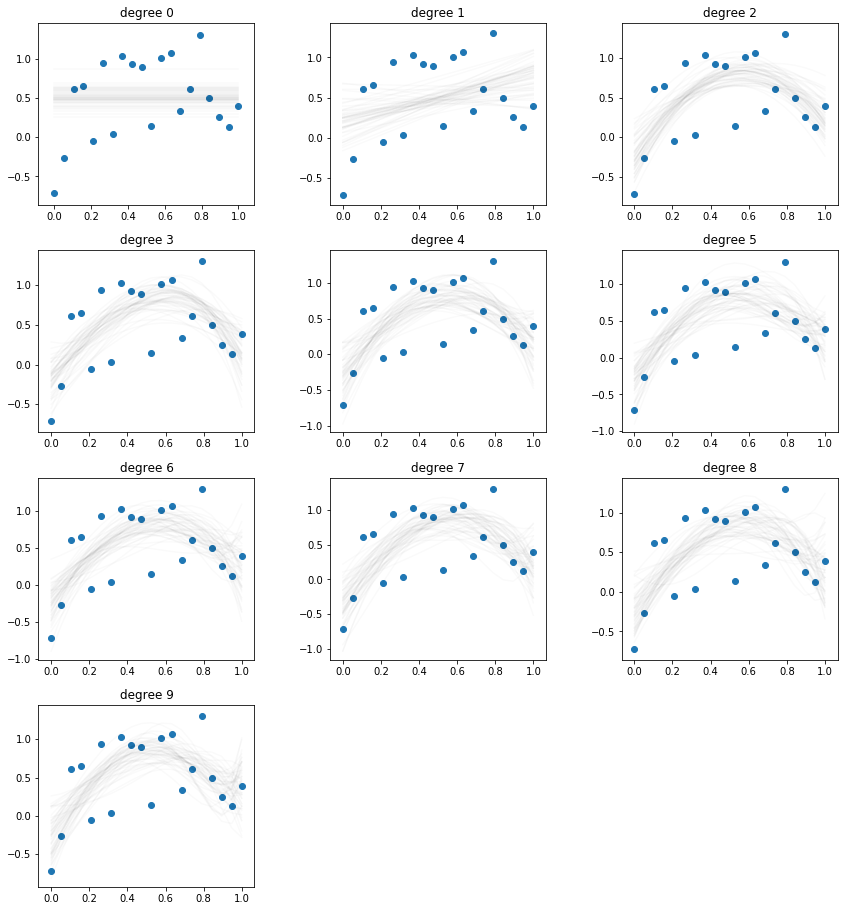

In [65]:
N_samp = 50

for i in range(degree):
    plt.subplot(int(float(degree)/3)+1,3,i+1)

    samples = post_sample_Laplace(models[i], N_samp)
    for l in range(N_samp):
        if i>0:
            pred = np.sum([x**k * samples[l,k] for k in range(i+1)],0)
        else:
            pred = x**0 * samples[l,0]
        plt.plot(x,pred, color = 'black', alpha = 0.02)
    
    plt.scatter(x,y)
    plt.title('degree ' + str(i))    
    plt.subplots_adjust(top=3, bottom=0.001, left=0.10, right=1.95, hspace=0.25,wspace=0.35)

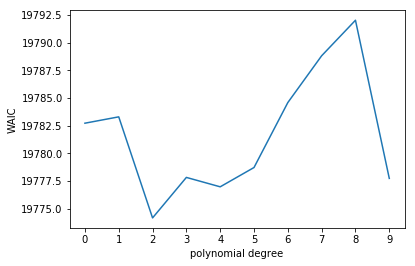

In [68]:
D = []

N_samp = 500

for i in range(degree):
    lppd = 0
    p_waic = 0
    samples = post_sample_Laplace(models[i], N_samp)
    for k,target in enumerate(y):
        log_p = []
        for l in range(len(samples)):
            if i>0:
                pred = np.sum([x**k * samples[l,k] for k in range(i+1)],0)
                log_p.append(norm.logpdf(target,pred[k],samples[k][-1]))
            else:
                pred = x**0 * samples[l,0]
                log_p.append(norm.logpdf(target,pred[k],samples[k][-1]))
    
        lppd += scipy.special.logsumexp(log_p) - len(log_p)
        p_waic += np.var(log_p)
    
#    print(lppd, p_waic)
    
    D.append(-2*( lppd - p_waic))   

plt.plot(range(degree),D)
plt.xticks(range(degree))
plt.xlabel('polynomial degree')
plt.ylabel('WAIC')
plt.show()